<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-ensembling-gradientboosting-with-lags-02?scriptVersionId=260643414" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

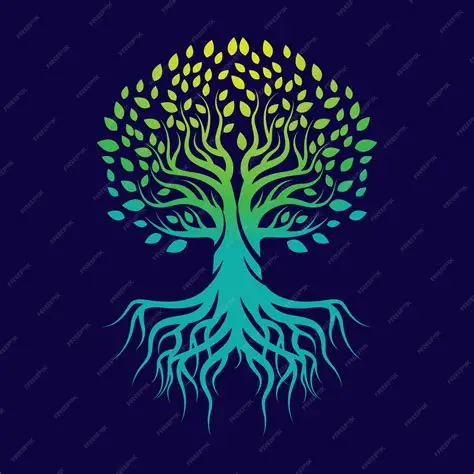

---

**In this notebook, we will use Ensembling Gradient Boosting trees for a multi-target regression problem, leveraging lagged targets to predict 424 outputs. To speed up inference, we adopt the long-format multi-output prediction method, which is much faster than the standard multi-output approach.**

**You will also find several useful techniques in this notebook, including:**

* How to create lagged targets and use them in the prediction step
* How to run Ensembling Gradient Boosting trees with lags targets
* How to build an optimized prediction function for API inference



---

In [1]:
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
trainl = trainl.fillna(0)

In [3]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [4]:
Features = [i for i in trainl.columns ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features[1:]:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [5]:
_,train_lagged = creat_lagged_labels(trainl)

In [6]:
train_lagged

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.000000,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,1956,0.002461,-0.000225,0.001229,-0.000627,0.000000,0.000000,-0.004208,0.007665,0.000000,...,0.000000,-0.006725,0.001344,0.000000,-0.050107,-0.017070,0.000000,-0.006722,0.000000,0.005249
1957,1957,0.002761,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,...,-0.000729,-0.008356,0.003985,0.012376,-0.043938,-0.013157,-0.000704,-0.035360,0.006352,0.006904
1958,1958,0.011424,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,...,0.009382,-0.012275,0.012132,0.030011,-0.037556,-0.009914,0.005984,-0.022557,0.029302,0.011154
1959,1959,-0.002654,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,...,-0.006255,0.005842,0.003945,-0.018496,-0.009460,-0.000114,-0.007490,-0.004104,-0.010907,-0.001935


In [7]:
# long-format multi-output predictions method:
import gc
training_df = []
target_cols = [f"target_{i}" for i in range(424)]
for j, target_col in enumerate(target_cols):
    temp_train_df = pd.DataFrame()
    temp_train_df[Features]  = train_lagged[Features]                     
    #temp_train_df = X_trains2.copy()
    temp_train_df['target_id'] = j
    y = trainl[target_col].values
    temp_train_df['target'] = y
    mask = ~(np.isnan(y) | np.isinf(y) | (np.abs(y) > 1e10))
    training_df.append(temp_train_df[mask].copy())
    del temp_train_df,y
    gc.collect()
training_df = pd.concat(training_df).reset_index(drop=True)

In [8]:
Features2 = Features + ["target_id"]
X_train = training_df[Features2]
y_train = training_df["target"]

In [9]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
# Deeper Gradient Boosting models for regression
xgb_model = XGBRegressor(
    n_estimators=2000,       # more boosting rounds
    max_depth=6,            # deeper trees
    learning_rate=0.01,      # smaller LR for stability
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    tree_method="hist",
    device="cuda"            # remove if no GPU
)
warnings.filterwarnings("ignore")
lgbm_model = LGBMRegressor(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.01,
    num_leaves=256,          # more leaves for depth
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    device="gpu"  ,           # remove if no GPU
    verbose=-1
)

catboost_model = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.01,
    l2_leaf_reg=3,
    #subsample=0.8,
    random_seed=42,
    loss_function='RMSE',
    task_type="GPU",         # remove if no GPU
    verbose=False
)

# Append models to a list for later training / ensembling
models = [xgb_model, lgbm_model, catboost_model]
Models = []
# Example usage: training all models
for model in models:
     model.fit(X_train, y_train)
     Models.append(model)
    

print(f"Models list created with {len(models)} models.")


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Models list created with 3 models.


In [10]:
def ensemble_predict(models, X):
    """
    Predict using a list of trained models and return the averaged prediction.
    
    Parameters:
        models : list of trained models
        X      : numpy array or DataFrame of features
        
    Returns:
        ensemble_pred : averaged prediction across models
    """
    preds = [model.predict(X) for model in models]
    ensemble_pred = np.mean(preds, axis=0)
    return ensemble_pred

In [11]:
#ensemble_predict(Models, X_train)

In [12]:
X_data = X_train.copy()
X_data["preds"] = ensemble_predict(Models, X_train)

In [13]:
X_train[Features2]

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423,target_id
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831459,1956,0.002461,-0.000225,0.001229,-0.000627,0.000000,0.000000,-0.004208,0.007665,0.000000,...,-0.006725,0.001344,0.000000,-0.050107,-0.017070,0.000000,-0.006722,0.000000,0.005249,423
831460,1957,0.002761,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,...,-0.008356,0.003985,0.012376,-0.043938,-0.013157,-0.000704,-0.035360,0.006352,0.006904,423
831461,1958,0.011424,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,...,-0.012275,0.012132,0.030011,-0.037556,-0.009914,0.005984,-0.022557,0.029302,0.011154,423
831462,1959,-0.002654,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,...,0.005842,0.003945,-0.018496,-0.009460,-0.000114,-0.007490,-0.004104,-0.010907,-0.001935,423


In [14]:
X_data

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423,target_id,preds
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.000094
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.000148
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000086
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000054
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310,0,-0.000313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831459,1956,0.002461,-0.000225,0.001229,-0.000627,0.000000,0.000000,-0.004208,0.007665,0.000000,...,0.001344,0.000000,-0.050107,-0.017070,0.000000,-0.006722,0.000000,0.005249,423,-0.002217
831460,1957,0.002761,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,...,0.003985,0.012376,-0.043938,-0.013157,-0.000704,-0.035360,0.006352,0.006904,423,-0.000986
831461,1958,0.011424,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,...,0.012132,0.030011,-0.037556,-0.009914,0.005984,-0.022557,0.029302,0.011154,423,-0.000681
831462,1959,-0.002654,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,...,0.003945,-0.018496,-0.009460,-0.000114,-0.007490,-0.004104,-0.010907,-0.001935,423,0.001512


In [15]:
ensemble_predict(Models, X_train[Features2])

array([-9.39132518e-05, -1.47977548e-04,  8.56325957e-05, ...,
       -6.80606100e-04,  1.51172810e-03,  2.35949497e-03])

In [16]:
X_data[["target_id","preds"]]

,target_id,preds
0,0,-0.000094
1,0,-0.000148
2,0,0.000086
3,0,0.000054
4,0,-0.000313
...,...,...
831459,423,-0.002217
831460,423,-0.000986
831461,423,-0.000681
831462,423,0.001512


In [17]:
# Step 1: Add row ID for test samples (0 to 89 repeated 424 times)
df_preds = X_data.copy()
df_preds['row'] = df_preds.groupby('target_id').cumcount()

# Step 2: Pivot the table to wide format
df_wide = df_preds.pivot(index='row', columns='target_id', values='preds')

# Step 3: Optionally, sort columns by target_id
df_wide = df_wide.sort_index(axis=1)
df_wide.index = [i for i in df_wide.index]
# Step 4: Rename columns (optional)
df_wide.columns = [f'target_{i}' for i in df_wide.columns]
df_wide
# Done: df_wide has shape (90, 424)

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,-9.391325e-05,-9.391325e-05,-9.645872e-05,-9.598061e-05,-9.598061e-05,-0.000101,-0.000101,-0.000101,-0.000101,-0.000069,...,0.000235,0.000221,0.000136,0.000200,0.000125,0.000113,0.000468,0.000537,0.000694,0.000633
1,-1.479775e-04,-1.479775e-04,-1.505230e-04,-1.500449e-04,-1.500449e-04,-0.000155,-0.000155,-0.000155,-0.000155,-0.000095,...,0.000199,0.000197,0.000120,0.000207,0.000163,0.000151,0.000464,0.000526,0.000869,0.000966
2,8.563260e-05,8.563260e-05,8.308716e-05,8.356526e-05,8.356526e-05,0.000079,0.000079,0.000075,0.000075,0.000080,...,-0.000335,-0.000535,-0.000593,-0.000631,-0.000855,-0.000867,-0.000495,-0.000477,0.000023,0.000294
3,5.428991e-05,5.428991e-05,5.428991e-05,5.476801e-05,5.476801e-05,0.000050,0.000050,0.000044,0.000044,0.000064,...,0.000227,0.000156,0.000058,0.000113,-0.000122,-0.000137,0.000224,0.000314,0.001179,0.001293
4,-3.127565e-04,-3.127565e-04,-3.153020e-04,-3.148239e-04,-3.148239e-04,-0.000324,-0.000324,-0.000334,-0.000334,-0.000301,...,-0.000857,-0.000920,-0.000969,-0.000920,-0.001080,-0.001086,-0.000943,-0.000923,0.000108,-0.000542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,4.338260e-07,4.338260e-07,4.338260e-07,9.119285e-07,9.119285e-07,-0.000007,-0.000007,-0.000007,-0.000007,0.000076,...,0.000299,0.000265,0.000223,0.000304,-0.000155,-0.000164,0.000281,0.000450,0.000814,-0.002217
1957,2.035151e-05,2.035151e-05,2.035151e-05,2.082961e-05,2.082961e-05,0.000011,0.000011,0.000011,0.000011,0.000134,...,0.000047,-0.000030,-0.000033,0.000087,-0.000270,-0.000251,0.000840,0.001073,0.001696,-0.000986
1958,-1.195358e-04,-1.195358e-04,-1.195358e-04,-1.190577e-04,-1.190577e-04,-0.000118,-0.000118,-0.000118,-0.000118,-0.000098,...,-0.000158,-0.000112,-0.000220,-0.000135,-0.000400,-0.000422,0.000158,0.000321,0.000307,-0.000681
1959,1.990623e-04,1.990623e-04,1.990623e-04,1.982144e-04,1.982144e-04,0.000196,0.000196,0.000190,0.000190,0.000289,...,0.001186,0.001205,0.001209,0.001426,0.001267,0.001265,0.001930,0.002146,0.002188,0.001512


In [18]:
#https://www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [19]:
score(trainl[Features[1:]],df_wide[Features[1:]])

1.4843872259601885

In [20]:
ycols = ['target_' + str(i) for i in range(424)]

In [21]:
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    Optimized for performance by:
    - Minimizing data conversions
    - Using vectorized operations
    - Reducing memory allocations
    - Parallelizing predictions where possible
    """
    # Combine lag features in one operation
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pl.DataFrame(0, schema=[(f"target_{i}", pl.Float64) for i in range(424)])
    
    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    # Prepare features for prediction in one go
    # Create all target_id combinations without materializing full DataFrame
    n_targets = 424
    n_rows = X_pred.height
    
    # Prepare features for all targets at once
    features_array = np.tile(X_pred[Features[1:]].to_numpy(), (n_targets, 1))
    target_ids = np.repeat(np.arange(n_targets), n_rows)
    # Create final prediction DataFrame efficiently
    X_pred2 = pl.DataFrame({
       "date_id": np.tile(X_pred[Features[0]].to_numpy(), n_targets),
       **{feat: features_array[:, i] for i, feat in enumerate(Features[1:])},
       "target_id": target_ids,
       "row": np.tile(np.arange(n_rows), 424)
    })
    # Predict in batches for memory efficiency
    #batch_size = 10000
    preds = np.zeros(len(X_pred2))

    preds = ensemble_predict(Models, X_pred2[Features2].to_pandas())
    X_pred2 = X_pred2.with_columns(pl.Series("preds", preds))
    # Pivot to wide format more efficiently
    df_wide = (
        X_pred2.lazy()
        .group_by(["target_id", "row"])
        .agg(pl.col("preds").first())
        .collect()
        .pivot(index="row", columns="target_id", values="preds")
        .sort("row")
    )

    # Ensure correct column order by sorting by target_id
    col_order = sorted([col for col in df_wide.columns if col != "row"], key=int)
    df_wide = df_wide.select(["row"] + col_order)

    # Rename columns to target_0 ... target_423
    df_wide.columns = ["row"] + [f"target_{i}" for i in range(424)]
    # Get column names in order
    target_cols = [f"target_{i}" for i in range(424)]
    df_wide = df_wide.select(target_cols)
    #print(df_wide)
    # Return last row as predictions
    return df_wide.tail(1).to_pandas()

In [22]:
# submission through the API

inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [23]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1827,-0.000141,-0.000141,-0.000141,-0.000141,-0.000141,-0.000146,-0.000146,-0.000145,-0.000145,-0.000114,-0.000104,-0.000085,-0.000085,-0.000085,-0.000085,-0.000122,-0.000122,-0.000134,-0.000134,-0.000134,-0.000136,-0.00016,-0.000165,-0.000165,-0.000165,-0.000165,-0.000146,-0.000144,-0.000144,-0.000179,-0.00018,-0.00018,-0.00018,-0.00017,-0.00017,-0.00017,…,-0.000412,-0.000412,-0.000402,-0.000477,-0.000658,-0.000662,-0.000549,-0.000899,-0.000952,-0.001007,-0.000532,-0.000734,-0.001234,-0.00085,-0.000845,-0.000859,-0.001186,0.000472,-0.000149,-0.000179,-0.000164,-0.000027,-0.000075,-0.000196,-0.000392,0.00051,-0.000203,0.000157,0.000145,0.00006,0.000123,0.000048,0.00004,0.000412,0.000486,0.000682,0.000241
1828,-0.000141,-0.000141,-0.000141,-0.000141,-0.000141,-0.000146,-0.000146,-0.000145,-0.000145,-0.000114,-0.000104,-0.000085,-0.000085,-0.000085,-0.000085,-0.000122,-0.000122,-0.000134,-0.000134,-0.000134,-0.000136,-0.00016,-0.000165,-0.000165,-0.000165,-0.000165,-0.000146,-0.000144,-0.000144,-0.000179,-0.00018,-0.00018,-0.00018,-0.00017,-0.00017,-0.00017,…,-0.000412,-0.000412,-0.000402,-0.000477,-0.000658,-0.000662,-0.000549,-0.000899,-0.000952,-0.001007,-0.000532,-0.000734,-0.001234,-0.00085,-0.000845,-0.000859,-0.001186,0.000472,-0.000149,-0.000179,-0.000164,-0.000027,-0.000075,-0.000196,-0.000392,0.00051,-0.000203,0.000157,0.000145,0.00006,0.000123,0.000048,0.00004,0.000412,0.000486,0.000682,0.000241
1829,-0.00018,-0.00018,-0.00018,-0.000179,-0.000179,-0.000184,-0.000184,-0.000184,-0.000184,-0.00016,-0.000153,-0.00013,-0.00013,-0.00013,-0.00013,-0.000167,-0.000167,-0.000179,-0.000179,-0.000179,-0.000181,-0.000203,-0.000203,-0.000203,-0.000203,-0.000208,-0.000186,-0.000184,-0.000184,-0.000224,-0.000225,-0.000225,-0.000225,-0.000203,-0.000203,-0.000203,…,-0.00048,-0.00048,-0.00047,-0.000552,-0.000738,-0.000742,-0.000629,-0.001002,-0.001056,-0.001103,-0.000625,-0.000828,-0.001327,-0.000931,-0.000926,-0.00094,-0.001267,0.000395,-0.000226,-0.000256,-0.000237,-0.000099,-0.000147,-0.000259,-0.000455,0.000427,-0.000266,0.000091,0.000066,-0.000006,0.000051,-0.000026,-0.000034,0.000347,0.000408,0.000602,0.000153
1830,-0.000115,-0.000115,-0.000115,-0.000116,-0.000116,-0.000125,-0.000125,-0.000131,-0.000131,-0.000106,-0.000096,-0.000102,-0.000102,-0.000102,-0.000102,-0.000078,-0.000078,-0.000083,-0.000083,-0.000059,-0.000055,-0.000075,-0.000078,-0.000078,-0.000078,-0.000085,-0.000058,-6.1816e-7,-6.1816e-7,-0.000198,-0.000194,-0.000194,-0.000194,-0.000092,-0.000092,-0.000092,…,-0.000236,-0.000236,-0.000219,-0.000216,-0.000422,-0.000422,-0.000323,-0.000807,-0.000864,-0.000907,-0.000538,-0.000534,-0.000979,-0.000558,-0.000543,-0.000529,-0.00098,0.000594,0.000084,0.000026,0.000041,0.000163,0.000082,-0.000019,0.000061,0.000791,-0.000037,0.000281,0.000301,0.00017,0.000204,0.000148,0.000139,0.000534,0.000565,0.00071,0.000473
1831,0.000252,0.000252,0.000252,0.000251,0.000251,0.000246,0.000246,0.000